In [1]:
!git clone -b main https://github.com/emilyyjordan/explorelib_test.git

fatal: destination path 'explorelib_test' already exists and is not an empty directory.


In [2]:
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/MattChanTK/gym-maze.git to /private/var/folders/v0/v5lvj9690t51ny6395nmfg2r0000gn/T/pip-req-build-qpgnh86b
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14254 sha256=187e9949f8ae291a8acbf1592443095f29e7fd64b30f2e002976c459478fe296
  Stored in directory: /private/var/folders/v0/v5lvj9690t51ny6395nmfg2r0000gn/T/pip-ephem-wheel-cache-caao67j3/wheels/c0/37/d4/f0a6f35e8f410ad1e28ac3a775cabb3c31905330fda0ab7a3a
Successfully built gym-maze
  Attempting uninstall: gym-maze
    Found existing installation: gym-maze 0.4
    Uninstalling gym-maze-0.4:
      Successfully uninstalled gym-maze-0.4


In [3]:
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import csv

import sys
sys.path.append('/Users/emily/Desktop/research/AdNet/explorelib_test/')

import explorationlib

from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditChange4
from explorationlib.local_gym import BanditUniform3
from explorationlib.local_gym import BanditAddictive2
from explorationlib.local_gym import BanditAnti2
from explorationlib.local_gym import BanditNeutral
from explorationlib.local_gym import BanditChange3
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import DeterministicActor
from explorationlib.agent import BanditAdNet

from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

Generator(PCG64)
Generator(PCG64)
sum of wholeDeckB: 950
sum of wholeDeckC: 390
[30, -25, 30, -20, 20, -25, -25, 25, -15, 30, 20, 20, 30, 25, -25, -25, -20, -25, -20, 25, 25, -25, -25, 25, 25, -20, 15, 25, 25, 20, 25, 25, 35, 25, 30, 25, -25, 30, 20, 25, 25, -35, 35, 20, -15, -30, 25, 20, -15, -25, -25, 25, 35, 20, -25, 30, -35, -30, -20, 25, -20, -25, -30, 35, -30, 20, 20, 25, 20, -10, -25, 30, 20, 20, -25, -25, 35, 20, 15, -30, -25, 25, 25, 25, 25, -25, -15, -15, -25, 20, -25, 30, 20, -30, 20, -20, -25, 20, 25, -20]


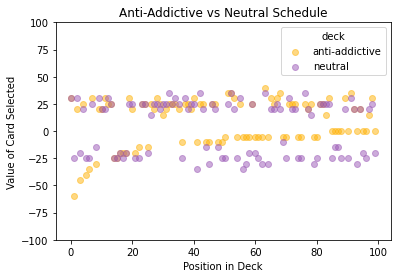

In [4]:
# Anti-addictive vs Neutral
# Shared env params
num_experiments = 1

# plot env before
envAnti = BanditAnti2()
envAnti.seed(seed = 42)
envAnti.plotDecks()

In [5]:
adn = BanditAdNet(
    SoftmaxActor(num_actions=envAnti.num_arms, beta=0.25),
    Critic(num_inputs=envAnti.num_arms, default_value=0.0),
    lr_pos=1.0, lr_neg=0.1
)

# -
agents = [adn]
names = ["adnet"]
colors = ["yellow"]

In [6]:
#running experiment with ANTI-addictive environment
num_steps = 100

anti_addictive_results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        envAnti,
        num_steps=num_steps,
        num_experiments=1,
        dump=False,
        split_state=False,
    )
    anti_addictive_results.append(log)

Generator(PCG64)


In [7]:
from IPython.display import clear_output

def agent_df(agmax, almax, astep, given_beta, given_gamma):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Gamma', 'propB', 'propC'])
    df = pd.DataFrame(dtype=float, columns=df_columns)

    for cycle in np.arange(0, 100, 1): #changed from 250 to 100

        #alpha gains should only be positive, 0 to 1 for example
        for lr_pos in np.arange(0, agmax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for lr_neg in np.arange(0, almax, astep):
                print(cycle)

                beta = given_beta
                gamma = given_gamma
                lr_pos, lr_neg, beta = np.round(lr_pos, 3), np.round(lr_neg, 3), np.round(beta, 3)
                envAnti = BanditAnti2()
                agent = BanditAdNet(SoftmaxActor(num_actions=envAnti.num_arms, beta=beta),
                                  Critic(num_inputs=envAnti.num_arms, default_value=0.0),
                                  lr_pos=lr_pos, lr_neg=lr_neg)

                data = log = experiment("envAnti",
                                        agent,
                                        envAnti,
                                        num_steps=100,
                                        num_experiments=1,
                                        dump=False,
                                        split_state=False,
                                        )

                propB = envAnti.deck_counters[0]/100.0
                propC = envAnti.deck_counters[1]/100.0

                trial_df = pd.DataFrame([[lr_pos, lr_neg, beta, gamma, propB, propC]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)
                clear_output()

    return df

In [ ]:
mydf6 = agent_df(0.5, 0.5, .025, .5, 1)

In [ ]:
# Saving Q-Agent data for Parameter analysis in a List of Q-Agent Dataframes
mydfs_dup = [mydf6]
mydfs = []

for df in mydfs_dup:
    df = df.groupby(['Alpha Gain', 'Alpha Loss'])[['Beta', 'Gamma','propB', 'propC']].mean().reset_index()
    mydfs.append(df)

In [ ]:
sns.set_theme()
sns.set_context("notebook", font_scale=1.5)

grid_kws = {"hspace": 0, "wspace": 0.2}
fig, axs = plt.subplots(1,1, figsize=(7,7), gridspec_kw=grid_kws)

df = mydfs[0]

print("heatmap values")
display(df)

# saving the dataframe

sys.path.append('/Users/emily/Desktop/research/AdNet/AdNetExplore/') #not sure this line is necessary

df.to_csv('AntiAddictiveHeatmap.csv', index=False)

In [ ]:
df = pd.read_csv('AntiAddictiveHeatmap.csv')

heatmap_dfB = pd.pivot(df, index = "Alpha Loss", columns = "Alpha Gain", values = "propB").astype('float')
sns.heatmap(heatmap_dfB, square = True, cmap='hot', vmin=0, vmax=0.5, xticklabels=4, yticklabels = 4, cbar=True, ax= axs).invert_yaxis() #cmap='RdBu_r'
beta = round(df["Beta"][0], 3)
gamma = round(df["Gamma"][0], 3)
fig.suptitle(f"\u03B2={beta}, \u03B3={gamma} \n", fontsize = 16)
axs.set(ylabel='$\u03B1_{Loss}$')
axs.set(xlabel='$\u03B1_{Gain}$')
axs.set_title("Proportion of Draws from Anti-Addictive Deck")